# 9-Topic Model of the Constantine Beys Corpus


## Initial Analysis

A quick comparison of the 5-, 7-, and 9-topic models gives us the following sets of topic labels, and we can already see some of the topics that appear in every model, even the much larger models. These topics appear in bold below.

><em>5-Topic Model:</em> Indigenous politics, <b>Leadership & Succession</b>, <b>Fall of Constantine</b>, Negotiations of Ahmed Bey, and Administration

><em>7-Topic Model:</em> <b>Ottoman-Tribal Negotiations</b> [which were not always peaceful, thus we see a number of military terms in this topic across the models], <b>Tribal rebellions</b>, <b>Leadership & Succession</b>, <b>Religion</b> [does not yet make the connection between religion and governance in the region], <b>Internal political upheaval</b>, <b>Public works</b>, and the <b>Fall of Constantine</b> to the French in 1837.

><em>9-Topic Model:</em> <b>Ottoman-Tribes Negotiations</b>, 1806 Tunisian siege of Constantine, <b>Leadership & Succession</b>, <b>Fall of Constantine</b>, <b>Public works</b>, Chimera topic: La Calle_Tunisia, <b>Religion</b>, <b>Grand tribes</b>, <b>Internal political upheaval</b>

## Experimental Visualizations

In [2]:
import pandas as pd

oa9_topics = pd.Cov = pd.read_csv("/Users/asg/mallet/output/OA-model/oa9-keys.csv", sep=',', names=["topic_number", "topic_weight", "top_words"])

oa9_topics.style.set_properties(subset=['top_words'], **{'width': '600px'})

,topic_number,topic_weight,top_words
0,0,0.21643,janissaires région milice gana kaïd mokrani sud hadj dey sultan makhzen chaouchs troupes saïd touggourt biens ouled auprès portes kaïd-dar
1,1,0.32341,camp l’armée habitants retraite hommes siège kabiles tunisiens cavaliers murs contingents marche fuite canons nombre portes courage commandement plaine aussitôt
2,2,1.75698,bey qu’il faire d’une ville temps pacha alger mort d’un province fils d’alger c’est nouveau turcs tête pays eut troupes
3,3,0.02484,général rue bône ben-gana france place français ville brèche batterie feu commandant colonel maréchal bataillon assiégés duc enfin valée mansoura
4,4,0.06931,touggourt zmala pont marabout espagnols tribu mosquée construire musulmans quartier medersa arches toutefois terres réaux travaux d’eau règlement qu’un medraça
5,5,0.34945,tunis troupes pacha france alger français dey algériens kef d’alger prit algérienne guerre bach-agha bastion l’armée calle tunisien tribut défaite
6,6,0.16326,cheïkh dieu beys sidi années l’hégire d’ali n’a l’homme l’histoire ans mourut j.-c arabe récit d’ailleurs s’est l’année dizaine écrit
7,7,0.20354,dey henanecha nommé région tunisie puis révolte sud famille indigènes daouaouida grande situation yoldach ben-gana règne kasba notamment rupture el-arab
8,8,0.16627,makhzen khalifa dieu bach-agha caïd-dar l’usurpateur joie chaouch chaouche tentes habitants tente plaintes parut lettre faible oreilles aller cupidité officiers


In [3]:
# Create a list of topic labels.
labels = ['Ott-Tribes Neg.', '1806 Tunisian siege', 'Leader._Success.', 'Fall of Con.', 'Public works', 'La Calle_Tunisia', 'Religion', 'Grand tribes', 'Internal pol upheaval']

# Add the labels list as a new column to the dataframe
oa9_topics['labels'] = labels

# Adjust the style of the dataframe so that the column of top_words is wide enough to see all of them.
oa9_topics.style.set_properties(subset=['top_words'], **{'width': '500px'})

,topic_number,topic_weight,top_words,labels
0,0,0.21643,janissaires région milice gana kaïd mokrani sud hadj dey sultan makhzen chaouchs troupes saïd touggourt biens ouled auprès portes kaïd-dar,Ott-Tribes Neg.
1,1,0.32341,camp l’armée habitants retraite hommes siège kabiles tunisiens cavaliers murs contingents marche fuite canons nombre portes courage commandement plaine aussitôt,1806 Tunisian siege
2,2,1.75698,bey qu’il faire d’une ville temps pacha alger mort d’un province fils d’alger c’est nouveau turcs tête pays eut troupes,Leader._Success.
3,3,0.02484,général rue bône ben-gana france place français ville brèche batterie feu commandant colonel maréchal bataillon assiégés duc enfin valée mansoura,Fall of Con.
4,4,0.06931,touggourt zmala pont marabout espagnols tribu mosquée construire musulmans quartier medersa arches toutefois terres réaux travaux d’eau règlement qu’un medraça,Public works
5,5,0.34945,tunis troupes pacha france alger français dey algériens kef d’alger prit algérienne guerre bach-agha bastion l’armée calle tunisien tribut défaite,La Calle_Tunisia
6,6,0.16326,cheïkh dieu beys sidi années l’hégire d’ali n’a l’homme l’histoire ans mourut j.-c arabe récit d’ailleurs s’est l’année dizaine écrit,Religion
7,7,0.20354,dey henanecha nommé région tunisie puis révolte sud famille indigènes daouaouida grande situation yoldach ben-gana règne kasba notamment rupture el-arab,Grand tribes
8,8,0.16627,makhzen khalifa dieu bach-agha caïd-dar l’usurpateur joie chaouch chaouche tentes habitants tente plaintes parut lettre faible oreilles aller cupidité officiers,Internal pol upheaval


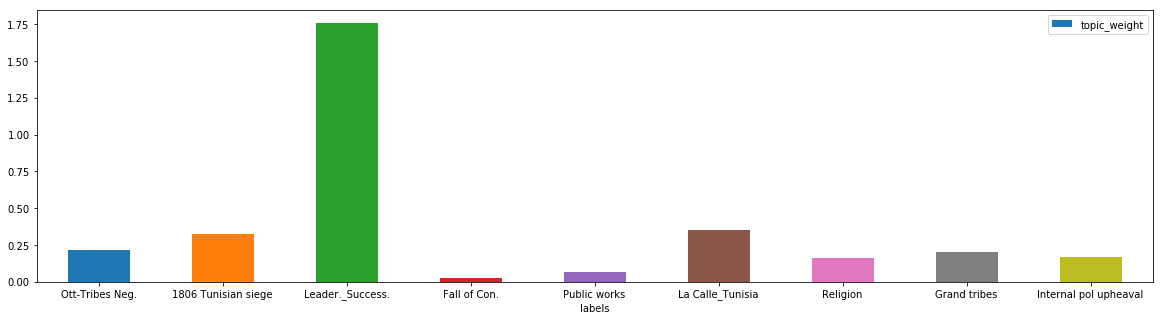

In [4]:
# Represent the weights of the topics as a simple bar chart, using the author-created topic labels. 

topic_bar = oa9_topics.plot.bar(x='labels', y='topic_weight', rot=0, figsize=(20,5))

In [6]:
# The mallet .txt doc-topics output file was converted to a csv, and the columns for 
# document numbers and filepaths were deleted in advance of reading the csv into a 
# pandas dataframe. Be sure to convert the columns to number data type with ~6 decimal places to remove the 
# exponential format. Also, add a new line at the top of the csv with the labels defined in the previous step.

oa9_docs = pd.Cov = pd.read_csv("/Users/asg/mallet/output/OA-model/oa9-doc-topics.csv", sep=',')

# Uncomment the following line to view dataframe
#oa9_docs

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

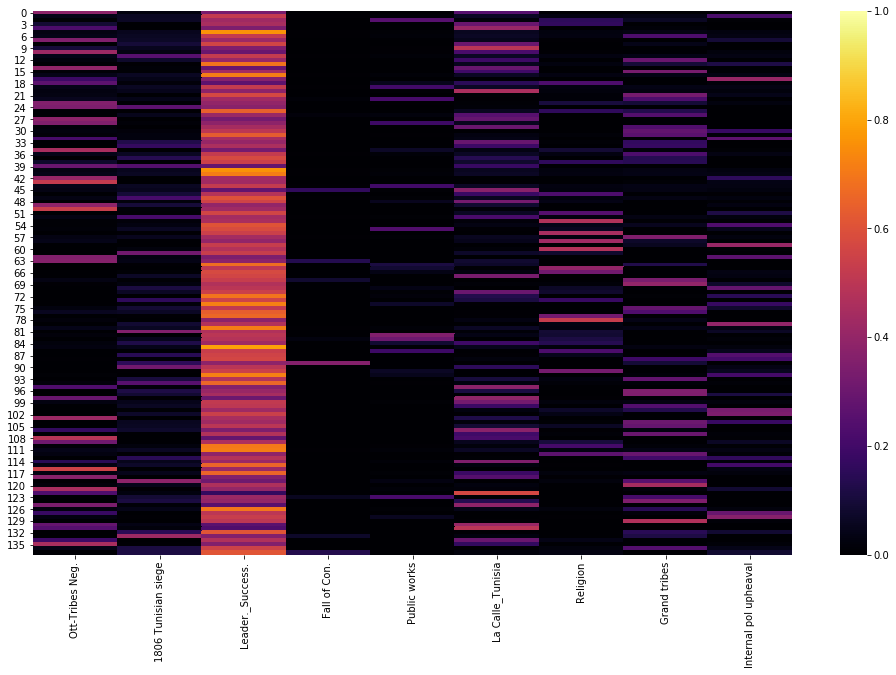

In [7]:
# Represent the topic weights in each document as a heatmap.

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (17.0, 10.0)

oa9_docs = oa9_docs[oa9_docs.columns].astype(float)

# Create a heatmap that is visually accessible (see https://matplotlib.org/tutorials/colors/colormaps.html)
# using the 'inferno' colormap. 

sns.heatmap(oa9_docs, cmap='inferno', vmin=0.0, vmax=1.0)

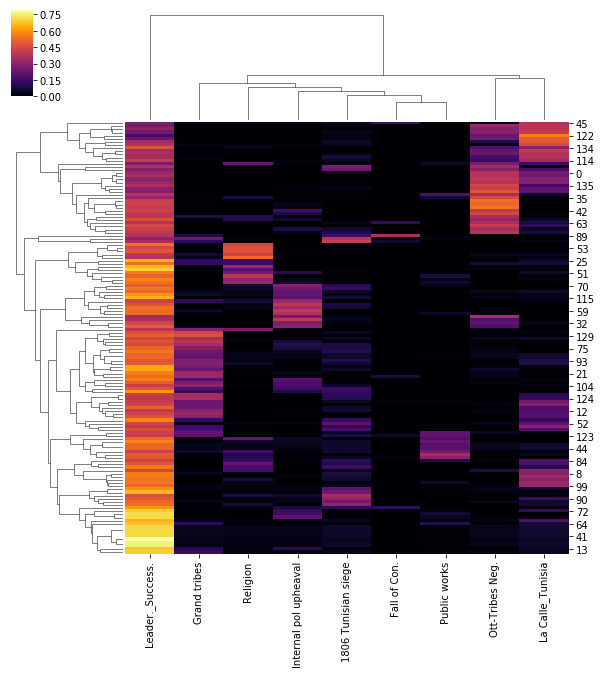

In [9]:
# Create a hierarchical heatmap using seaborn's "clustermap" method with default settings.
# By default this method will cluster by both rows and columns, which is what is most useful for this data.

sns.clustermap(oa9_docs, cmap='inferno')

## Visualizing Mallet output with pyLDAvis
You will need to generate MALLET's output-topic-states <b>gz</b> file to prepare the MALLET output in the format needed by pyLDAvis. I didn't know about this possibility, so I had to run MALLET again, creating a different 5-topic model than the ones visualized above. 

Huge thanks to <a href="https://jeriwieringa.com/about/">Jeri E. Wieringa</a> for making this connection and sharing all of the code! You can find her explanation and code at <a href="https://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/">"Using pyLDAvis with Mallet."</a>

In [27]:
import pandas as pd
import gzip
import os

dataDir = "/Users/asg/mallet/output/OA-model/"

def extract_params(statefile):
    """Extract the alpha and beta values from the statefile. 
    
    Args:
        statefile (str): Path to the statefile produced by Mallet.
    Returns:
        tuple: alpha (list), beta
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf-8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))

def state_to_df(statefile):
    """Transform state file into pandas dataframe. 
    The Mallet statefile is tab-separated, and the first two rows contain the alpha and beta hyperparameters.
    
    Args:
        statefile (str): Path to statefile produced by Mallet.
    Returns:
        dataframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                      compression='gzip',
                      sep=' ',
                      skiprows=[1,2]
                      )

In [20]:
params = extract_params(os.path.join(dataDir, 'oa9-topic-state.gz'))

alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

df = state_to_df(os.path.join(dataDir, 'oa9-topic-state.gz'))

[0.21643402806355239, 0.3234136774257482, 1.7569832677512662, 0.024844683515057787, 0.06930723228392457, 0.34945168610637367, 0.16325988915938713, 0.20354210248367857, 0.1662741857413399], 0.11425618862977559


In [25]:
# Define column 'type' as a string to avoid nan pandas errors.
df['type'] = df.type.astype(str)

# Preview the dataframe from the statefile, which will then be used to generate the data needed for the 
# LDAvis library. 
df[:4]

,#doc,source,pos,typeindex,type,topic
0,0,data/OttAlg/gaid-36.txt,0,0,naaman-bey,0
1,0,data/OttAlg/gaid-36.txt,1,1,mai,2
2,0,data/OttAlg/gaid-36.txt,2,2,turc,2
3,0,data/OttAlg/gaid-36.txt,3,3,naissance,2


<b>Step 1:</b> We need the length of the documents. To do this, Jeri grouped the data by document id and counted the tokens in the doc. This data is then sorted by the doc id, so it will be in the correct order for visualization pre-processing.

In [26]:
# Get document lengths from statefile.
docs = df.groupby('#doc')['type'].count().reset_index(name='doc_length')

# Preview the gathered & grouped data:
docs[:4]

,#doc,doc_length
0,0,608
1,1,2
2,2,17
3,3,321


<b>Step 2:</b> We need the voabulary and frequencies. Jeri used pandas to generate a new frame with the word counts. She then sorted this df so that it is alphabetical by type, a step that will need to be repeated when creating the topic-term matrix because the order matters and must be kept consistent. Just as in Jeri's example, I, too, have OCR errors (see the first entry in the vocab dataframe above).

In [27]:
# Get vocab and term frequencies from the statefile.
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

# Preview the resulting dataframe
vocab[:4]

,type,term_freq
14610,a*tes,1
13447,a-t-elle,1
5173,a-t-il,3
7871,abaissement,2


<b>Step 3:</b> Create matrix files. The values need to be smoothed and the data normalized so that each row sums to 1. Jeri used sklearn to handle large matrices efficiently. 

In [34]:
# Topic-term matrix from state file.

import sklearn.preprocessing

def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe row to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable (str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    return pd.DataFrame(normed)

<b>Step 4:</b> [From Jeri's post] Next, we need to aggregate the data from the statefile dataframe to get the nmber of topic assignments for words in the documents. For <b>phi</b>, the topic-term matrix, [she] aggregated by topic and word, counted the number of times each word was assigned to each topic, and then sorted the resulting dataframe alphabetically by word, so that it matches the order of the vocabulary frame. Here, [she] used the <b>beta</b> hyperparameter as the smoothing value.

In [35]:
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)

phi_df[:10]

phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')

phi[:10]

,0,1,2,3,4,5,6,7,8,9,...,16844,16845,16846,16847,16848,16849,16850,16851,16852,16853
0,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000293,0.000015,0.000108,0.000108
1,0.000016,0.000016,0.000016,0.000016,0.000016,0.000115,0.000115,0.000016,0.000016,0.000016,...,0.000215,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
2,0.000003,0.000003,0.000003,0.000045,0.000003,0.000003,0.000003,0.000087,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000066,0.000003,0.000003,0.000024,0.000003
3,0.000158,0.000158,0.000022,0.000022,0.000022,0.000022,0.000022,0.000158,0.000022,0.000158,...,0.000022,0.000022,0.000158,0.000022,0.000158,0.000022,0.000022,0.000840,0.000295,0.000022
4,0.000018,0.000018,0.000134,0.000018,0.000018,0.000018,0.000250,0.000366,0.000134,0.000018,...,0.000018,0.000018,0.000018,0.000134,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018
5,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,...,0.000025,0.000179,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025
6,0.000018,0.000018,0.000239,0.000018,0.000128,0.000018,0.000128,0.000018,0.000018,0.000018,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000018,0.000460,0.000018,0.000018


<b>Step 5:</b> We do the same thing again, but focused on the documents and topics (rather than words & topics) to generate the <b>theta</b> document-topic matrix. Here, <b>alpha</b> is used as the smoothing value.

In [30]:
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta_df[:10]

theta = pivot_and_smooth(theta_df, alpha, '#doc', 'topic', 'topic_count')

theta[:10]

,0,1,2,3,4,5,6
0,0.477123,0.000307,0.485855,0.000251,0.000235,0.036168,0.000060
1,0.048171,0.273339,0.584362,0.035318,0.033028,0.017311,0.008473
2,0.010817,0.216468,0.389702,0.369807,0.007416,0.003887,0.001903
3,0.235691,0.000579,0.505772,0.257167,0.000444,0.000233,0.000114
4,0.501704,0.025963,0.423469,0.048054,0.000455,0.000238,0.000117
5,0.039156,0.409325,0.475005,0.028708,0.026847,0.014071,0.006887
6,0.278392,0.043118,0.584362,0.035318,0.033028,0.017311,0.008473
7,0.350657,0.001452,0.514848,0.005413,0.127556,0.000050,0.000024
8,0.001094,0.115955,0.880815,0.000802,0.000750,0.000393,0.000192
9,0.422061,0.002765,0.525309,0.042282,0.000334,0.007163,0.000086


The above processing steps represent about 90% of the work needed to prepare the mallet data for visualization with the LDAvis library. Now that all of the data has been formatted for pyLDAvis, we can queue it up and pass it to the visualization library.

In [31]:
import pyLDAvis

data = {'topic_term_dists': phi,
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
}

vis_data = pyLDAvis.prepare(**data)

pyLDAvis.display(vis_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
